In [1]:
import time
import os
import math
import cv2
import numpy as np
import pandas as pd
import pyautogui as pa
import shutil
import imageio
from PIL import Image, ImageDraw
import random
from scipy.stats import norm, kstest, sem, ttest_ind, linregress
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from lib.analysis.trace_metrics import TraceMetrics
from lib.analysis.false_discovery_control import false_discovery_control
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import * 
from lib.file.TIF import *
from lib.analysis.align import ImageAlign
from lib.utilities import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.ROI_reader import ROIFileReader
from lib.analysis.barrel_roi import Barrel_ROI_Creator


In [2]:
# load trace files from the following directory
data_dir = "C:/Users/jjudge3/Desktop/Data/single_cell_stim/scnn1a/"
export_summary = data_dir + "export_summary_single_px_backup.csv"
px_df = pd.read_csv(export_summary)
barrel_export_summaries = [data_dir + "/10-06-25/" + "export_summary.csv",
                           data_dir + "/09-18-25/" + "export_summary_barrel.csv",]
'''export_summary_barrel = data_dir + "/10-06-25/" + "export_summary.csv"
barrel_df = pd.read_csv(export_summary_barrel)

# populate px_df from barrel_df in columns: Stim_Target and Stim_Current
# match on Date, Slice, Location, Recording
for i, row in px_df.iterrows():
    date = row['Date']
    slice_id = row['Slice']
    location = row['Location']
    recording = row['Recording']
    match = barrel_df[
        (barrel_df['Date'] == date) & 
        (barrel_df['Slice'] == slice_id) & 
        (barrel_df['Location'] == location) & 
        (barrel_df['Recording'] == recording)
    ]
    if not match.empty:
        px_df.at[i, 'Stim_Target'] = match.iloc[0]['Stim_Target']
        px_df.at[i, 'Stim_Current'] = match.iloc[0]['Stim_Current']

# save updated px_df
px_df.to_csv(export_summary, index=False)'''

merged_barrel_export_summaries = []
for barrel_export_summary in barrel_export_summaries:
    barrel_df = pd.read_csv(barrel_export_summary)
    merged_barrel_export_summaries.append(barrel_df)
barrel_df = pd.concat(merged_barrel_export_summaries, ignore_index=True)
barrel_df

,ROI,amp,X_Center,Y_Center,ROI_Set,Date,Slice,Location,Recording,trace,amp_array,Stim_Current,Stim_Target,Drug
0,1,6.652090,49.849741,55.912781,1_1_rois,10/6/2025,1,1,1,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,95,random,ACSF
1,1,1.522970,49.849741,55.912781,1_1_rois,10/6/2025,1,1,2,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,40,random,ACSF
2,1,0.462068,49.849741,55.912781,1_1_rois,10/6/2025,1,1,3,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,20,random,ACSF
3,1,0.867729,49.849741,55.912781,1_1_rois,10/6/2025,1,1,4,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,30,random,ACSF
4,1,4.167740,49.849741,55.912781,1_1_rois,10/6/2025,1,1,5,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,70,random,ACSF
5,1,0.918962,47.185440,41.041209,1_2_rois,10/6/2025,1,2,1,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,70,SC,ACSF
6,1,1.546450,47.185440,41.041209,1_2_rois,10/6/2025,1,2,2,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,110,SC,ACSF
7,1,2.281210,47.185440,41.041209,1_2_rois,10/6/2025,1,2,3,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,150,SC,ACSF
8,1,0.459514,47.185440,41.041209,1_2_rois,10/6/2025,1,2,4,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,40,SC,ACSF
9,1,0.549716,47.185440,41.041209,1_2_rois,10/6/2025,1,2,5,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,60,SC,ACSF


In [3]:
def read_traces_file(filename): 
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=0)
    return data_arr

def read_array_file(filename): 
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Values'])
    return np.array(data_arr['Values']).reshape((80, 80))


In [4]:
'''# for each Date, Slice, Location, Recording in px_df, read in all 100 rows X_Center and Y_Center, 
# and calculate average X and Y coordinate
# then store Dist_from_Center in px_df
um_per_pixel = 6.0
px_df['Dist_from_Center'] = np.nan
for date in px_df['Date'].unique():
    date_df = px_df[px_df['Date'] == date]
    for slice in date_df['Slice'].unique():
        slice_df = date_df[date_df['Slice'] == slice]
        for location in slice_df['Location'].unique():
            loc_df = slice_df[slice_df['Location'] == location]
            for recording in loc_df['Recording'].unique():
                rec_df = loc_df[loc_df['Recording'] == recording]
                x_coords = rec_df['X_Center'].values
                y_coords = rec_df['Y_Center'].values
                avg_x = np.mean(x_coords)
                avg_y = np.mean(y_coords)
                dist_from_center = np.sqrt((x_coords - avg_x)**2 + (y_coords - avg_y)**2) * um_per_pixel
                px_df.loc[rec_df.index, 'Dist_from_Center'] = dist_from_center
# save updated px_df
px_df.to_csv(export_summary, index=False)'''

"# for each Date, Slice, Location, Recording in px_df, read in all 100 rows X_Center and Y_Center, \n# and calculate average X and Y coordinate\n# then store Dist_from_Center in px_df\num_per_pixel = 6.0\npx_df['Dist_from_Center'] = np.nan\nfor date in px_df['Date'].unique():\n    date_df = px_df[px_df['Date'] == date]\n    for slice in date_df['Slice'].unique():\n        slice_df = date_df[date_df['Slice'] == slice]\n        for location in slice_df['Location'].unique():\n            loc_df = slice_df[slice_df['Location'] == location]\n            for recording in loc_df['Recording'].unique():\n                rec_df = loc_df[loc_df['Recording'] == recording]\n                x_coords = rec_df['X_Center'].values\n                y_coords = rec_df['Y_Center'].values\n                avg_x = np.mean(x_coords)\n                avg_y = np.mean(y_coords)\n                dist_from_center = np.sqrt((x_coords - avg_x)**2 + (y_coords - avg_y)**2) * um_per_pixel\n                px_df.loc[rec_

Processing Date: 10/6/2025, Slice: 1, Location: 1, Stim_Target: random
Processing Date: 10/6/2025, Slice: 1, Location: 2, Stim_Target: SC


c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Date: 10/6/2025, Slice: 1, Location: 3, Stim_Target: SC
Processing Date: 10/6/2025, Slice: 1, Location: 4, Stim_Target: SC
Processing Date: 10/6/2025, Slice: 2, Location: 1, Stim_Target: SC
Could not fit logistic curve for Date: 10/6/2025, Slice: 2, Location: 1, Stim_Target: SC
Processing Date: 10/6/2025, Slice: 2, Location: 2, Stim_Target: SC
Processing Date: 10/6/2025, Slice: 2, Location: 3, Stim_Target: SC
Processing Date: 9/18/2025, Slice: 1, Location: 1, Stim_Target: SC
Processing Date: 9/18/2025, Slice: 1, Location: 2, Stim_Target: random
Processing Date: 9/18/2025, Slice: 1, Location: 3, Stim_Target: random
Processing Date: 9/18/2025, Slice: 1, Location: 4, Stim_Target: SC


c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Processing Date: 9/18/2025, Slice: 2, Location: 1, Stim_Target: random
Processing Date: 9/18/2025, Slice: 2, Location: 2, Stim_Target: SC


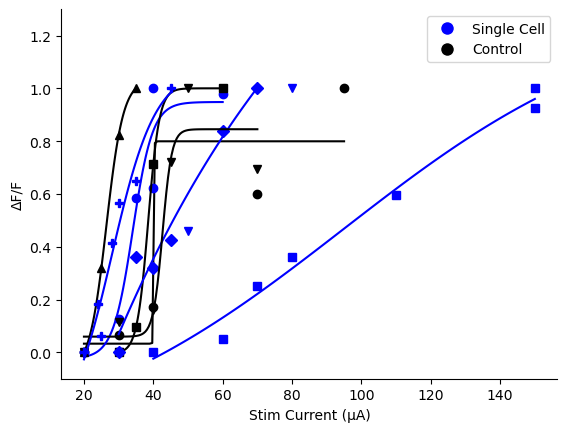

In [12]:
# For each date/slice/loc, make a curve of amplitude versus Stim_Current
# fit a logistic curve to the data of each date/slice/loc
colors = ['b', 'k', 'g', 'r', 'c', 'm', 'y']
markers = ['o', 's', '^', 'D', 'v', 'P', '*']
steepness_coefficients = {'SC': [], 'random': []}
center_coefficients = {'SC': [], 'random': []}
quality_of_fit = {'SC': [], 'random': []}
plt.figure()
i_color = -1
i_marker = -1
df = barrel_df  # use px_df or barrel_df
for date in df['Date'].unique():
    date_df = df[df['Date'] == date]
    for slice in date_df['Slice'].unique():
        slice_df = date_df[date_df['Slice'] == slice]

        for loc in slice_df['Location'].unique():
            loc_df = slice_df[slice_df['Location'] == loc]

            

            # read in value of Stim_Target
            stim_target = loc_df['Stim_Target'].values[0]
            print(f'Processing Date: {date}, Slice: {slice}, Location: {loc}, Stim_Target: {stim_target}')
            i_marker += 1
            i_color = 0 if stim_target == "SC" else 1
            for roi in loc_df['ROI'].unique():
                roi_df = loc_df[loc_df['ROI'] == roi]

                # restrict to drug == 'ACSF'
                roi_df = roi_df[roi_df['Drug'] == 'ACSF']

                # restrict to ROI with Dist_from_Center > 50 um
                #roi_df = roi_df[roi_df['Dist_from_Center'] > 50]

                if len(roi_df) > 0:
                    # normalize amp to 0-1 scale
                    roi_df['amp'] = (roi_df['amp'] - roi_df['amp'].min()) / (roi_df['amp'].max() - roi_df['amp'].min()) 
                    plt.plot(roi_df['Stim_Current'], roi_df['amp'], marker=markers[i_marker % len(markers)], linestyle='None',
                             label="Single Cell" if stim_target == "SC" else "Control", color=colors[i_color % len(colors)])
                else:
                    continue
                # Fit a logistic curve
                def logistic(x, L ,x0, k, b):
                    return L / (1 + np.exp(-k*(x-x0))) + b
                fit_success = False
                try:
                    p0 = [max(roi_df['amp']), np.median(roi_df['Stim_Current']),1,min(roi_df['amp'])] # initial guesses
                    popt, _ = curve_fit(logistic, roi_df['Stim_Current'], roi_df['amp'], maxfev=10000, p0=p0)
                    x_fit = np.linspace(min(roi_df['Stim_Current']), max(roi_df['Stim_Current']), 100)
                    y_fit = logistic(x_fit, *popt)
                    fit_success = True
                except:
                    print(f'Could not fit logistic curve for Date: {date}, Slice: {slice}, Location: {loc}, Stim_Target: {stim_target}')

                if fit_success:
                    plt.plot(x_fit, y_fit, label=f'Fit {date} {slice}-{loc}', color=colors[i_color % len(colors)])
                    steepness_coefficients[stim_target].append(popt[2]) # k is the steepness
                    center_coefficients[stim_target].append(popt[1]) # x0 is the center
                    quality_of_fit[stim_target].append(np.corrcoef(logistic(roi_df['Stim_Current'], *popt), roi_df['amp'])[0,1]**2)
                else:
                    steepness_coefficients[stim_target].append(np.nan)
                    center_coefficients[stim_target].append(np.nan)
                    # record 0 for quality of fit if fit failed
                    quality_of_fit[stim_target].append(0)
plt.xlabel('Stim Current (µA)')
plt.ylabel('ΔF/F')
plt.ylim(-0.1, 1.3)
# legend: SC (blue) versus random (black)
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label='Single Cell', markerfacecolor='b', markersize=10),
                        plt.Line2D([0], [0], marker='o', color='w', label='Control', markerfacecolor='k', markersize=10)])
# spines off
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

Processing Date: 9/18/2025, Slice: 1, Location: 1, Stim_Target: SC
Processing Date: 9/18/2025, Slice: 1, Location: 2, Stim_Target: random
Processing Date: 9/18/2025, Slice: 1, Location: 3, Stim_Target: random
Processing Date: 9/18/2025, Slice: 1, Location: 4, Stim_Target: SC
Processing Date: 9/18/2025, Slice: 2, Location: 1, Stim_Target: random
Processing Date: 9/18/2025, Slice: 2, Location: 2, Stim_Target: SC
Processing Date: 10/6/2025, Slice: 1, Location: 1, Stim_Target: random
Processing Date: 10/6/2025, Slice: 1, Location: 2, Stim_Target: SC
Processing Date: 10/6/2025, Slice: 1, Location: 3, Stim_Target: SC
Processing Date: 10/6/2025, Slice: 1, Location: 4, Stim_Target: SC
Processing Date: 10/6/2025, Slice: 2, Location: 1, Stim_Target: SC
Processing Date: 10/6/2025, Slice: 2, Location: 2, Stim_Target: SC
Processing Date: 10/6/2025, Slice: 2, Location: 3, Stim_Target: SC


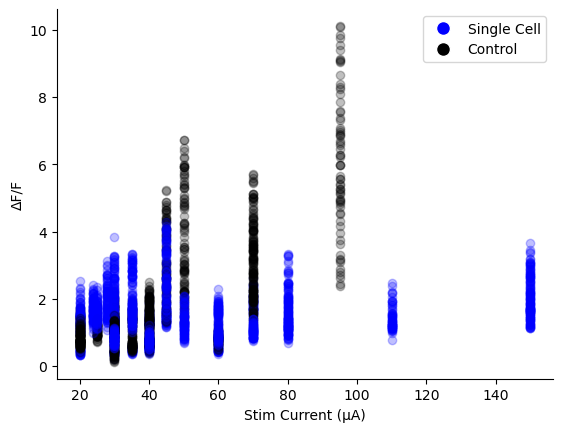

In [6]:
# For each date/slice/loc, make a curve of amplitude versus Stim_Current
# fit a logistic curve to the data of each date/slice/loc
colors = ['b', 'k', 'g', 'r', 'c', 'm', 'y']
markers = ['o', 's', '^', 'D', 'v', 'P', '*']
plt.figure()
i_color = -1
i_marker = -1
df = px_df  # use px_df or barrel_df
for date in df['Date'].unique():
    date_df = df[df['Date'] == date]
    for slice in date_df['Slice'].unique():
        slice_df = date_df[date_df['Slice'] == slice]

        for loc in slice_df['Location'].unique():
            loc_df = slice_df[slice_df['Location'] == loc]

            

            # read in value of Stim_Target
            stim_target = loc_df['Stim_Target'].values[0]
            print(f'Processing Date: {date}, Slice: {slice}, Location: {loc}, Stim_Target: {stim_target}')
            i_marker += 1
            i_color = 0 if stim_target == "SC" else 1
            for roi in loc_df['ROI'].unique():
                roi_df = loc_df[loc_df['ROI'] == roi]

                # restrict to drug == 'ACSF'
                roi_df = roi_df[roi_df['Drug'] == 'ACSF']

                # restrict to ROI with Dist_from_Center > 50 um
                roi_df = roi_df[roi_df['Dist_from_Center'] > 50]

                if len(roi_df) > 0:
                    plt.plot(roi_df['Stim_Current'], roi_df['amp'], marker='o', linestyle='None',
                             label="Single Cell" if stim_target == "SC" else "Control", color=colors[i_color % len(colors)], alpha=0.25)

plt.xlabel('Stim Current (µA)')
plt.ylabel('ΔF/F')
# legend: SC (blue) versus random (black)
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label='Single Cell', markerfacecolor='b', markersize=10),
                        plt.Line2D([0], [0], marker='o', color='w', label='Control', markerfacecolor='k', markersize=10)])
# spines off
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

Processing Date: 9/18/2025, Slice: 1, Location: 1, Stim_Target: SC
R^2 Logistic: 0.996, R^2 Linear: 0.733, R^2 Linear (adj): 0.466 R^2 Logistic (adj): -inf
Processing Date: 9/18/2025, Slice: 1, Location: 2, Stim_Target: random
R^2 Logistic: 1.000, R^2 Linear: 0.817, R^2 Linear (adj): 0.452 R^2 Logistic (adj): 1.000
Processing Date: 9/18/2025, Slice: 1, Location: 3, Stim_Target: random


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_11708\392280929.py:63: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared_adj_log = 1 - (1 - r_squared_log) * (n - 1) / (n - p - 1)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


R^2 Logistic: 1.000, R^2 Linear: 0.994, R^2 Linear (adj): 0.982 R^2 Logistic (adj): 1.000
Processing Date: 9/18/2025, Slice: 1, Location: 4, Stim_Target: SC
R^2 Logistic: 0.953, R^2 Linear: 0.953, R^2 Linear (adj): 0.922 R^2 Logistic (adj): 0.765
Processing Date: 9/18/2025, Slice: 2, Location: 1, Stim_Target: random
R^2 Logistic: 0.900, R^2 Linear: 0.521, R^2 Linear (adj): 0.201 R^2 Logistic (adj): 0.499
Processing Date: 9/18/2025, Slice: 2, Location: 2, Stim_Target: SC
R^2 Logistic: 0.946, R^2 Linear: 0.915, R^2 Linear (adj): 0.872 R^2 Logistic (adj): 0.837
Processing Date: 10/6/2025, Slice: 1, Location: 1, Stim_Target: random


c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_11708\392280929.py:63: RuntimeWarning: divide by zero encountered in double_scalars
  r_squared_adj_log = 1 - (1 - r_squared_log) * (n - 1) / (n - p - 1)


R^2 Logistic: 0.888, R^2 Linear: 0.988, R^2 Linear (adj): 0.977 R^2 Logistic (adj): -inf
Processing Date: 10/6/2025, Slice: 1, Location: 2, Stim_Target: SC
R^2 Logistic: 0.996, R^2 Linear: 0.996, R^2 Linear (adj): 0.993 R^2 Logistic (adj): 0.980
Processing Date: 10/6/2025, Slice: 1, Location: 3, Stim_Target: SC
Processing Date: 10/6/2025, Slice: 1, Location: 4, Stim_Target: SC
Processing Date: 10/6/2025, Slice: 2, Location: 1, Stim_Target: SC
Could not fit logistic curve for Date: 10/6/2025, Slice: 2, Location: 1, Stim_Target: SC
Processing Date: 10/6/2025, Slice: 2, Location: 2, Stim_Target: SC
Processing Date: 10/6/2025, Slice: 2, Location: 3, Stim_Target: SC


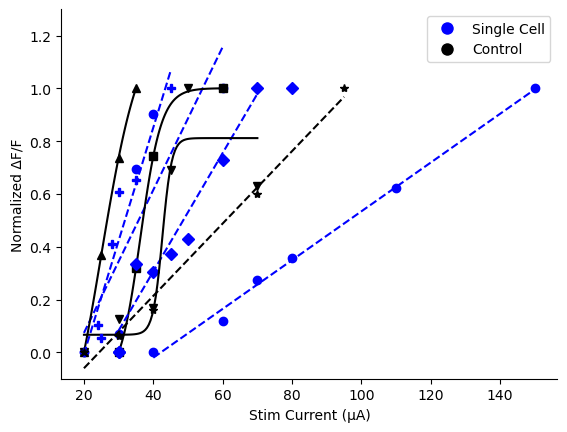

In [ ]:
# For each date/slice/loc, make a curve of amplitude versus Stim_Current
# fit a logistic curve to the data of each date/slice/loc
colors = ['b', 'k', 'g', 'r', 'c', 'm', 'y']
markers = ['o', 's', '^', 'D', 'v', 'P', '*']
steepness_coefficients = {'SC': [], 'random': []}
center_coefficients = {'SC': [], 'random': []}
quality_of_fit = {'SC': [], 'random': []}
plt.figure()
i_color = -1
i_marker = -1
df = px_df  # use px_df or barrel_df
for date in df['Date'].unique():
    date_df = df[df['Date'] == date]
    for slice in date_df['Slice'].unique():
        slice_df = date_df[date_df['Slice'] == slice]

        for loc in slice_df['Location'].unique():
            loc_df = slice_df[slice_df['Location'] == loc]

            # read in value of Stim_Target
            stim_target = loc_df['Stim_Target'].values[0]
            print(f'Processing Date: {date}, Slice: {slice}, Location: {loc}, Stim_Target: {stim_target}')
            i_marker += 1
            i_color = 0 if stim_target == "SC" else 1
            
            # restrict to drug == 'ACSF'
            loc_df = loc_df[loc_df['Drug'] == 'ACSF']

            # restrict to ROI with Dist_from_Center > x um
            loc_df = loc_df[loc_df['Dist_from_Center'] < 75]

            # average over all ROIs for each stim current
            loc_df = loc_df.groupby('Stim_Current', as_index=False).agg({'amp': 'mean', 'ROI': 'count', 'Dist_from_Center': 'mean'})

            if len(loc_df) > 0:
                # normalize amp to 0-1 scale
                #loc_df['amp'] = (loc_df['amp'] - loc_df['amp'].min()) / (loc_df['amp'].max() - loc_df['amp'].min())
                plt.plot(loc_df['Stim_Current'], loc_df['amp'], marker=markers[i_marker % len(markers)], linestyle='None',
                         label="Single Cell" if stim_target == "SC" else "Control", color=colors[i_color % len(colors)])
            else:
                continue
            # Fit a logistic curve
            def logistic(x, L ,x0, k, b):
                return L / (1 + np.exp(-k*(x-x0))) + b
            fit_success = False
            linear_better_fit = False
            try:
                p0 = [max(loc_df['amp']), np.median(loc_df['Stim_Current']),1,min(loc_df['amp'])] # initial guesses
                popt, _ = curve_fit(logistic, loc_df['Stim_Current'], loc_df['amp'], maxfev=10000, p0=p0)
                x_fit = np.linspace(min(loc_df['Stim_Current']), max(loc_df['Stim_Current']), 100)
                y_fit = logistic(x_fit, *popt)
                fit_success = True

                # try also a linear fit and compare R^2
                def linear(x, m, b):
                    return m * x + b
                p0 = [5/100, 0]
                popt_lin, _ = curve_fit(linear, loc_df['Stim_Current'], loc_df['amp'], maxfev=10000, p0=p0)
                r_squared_log = np.corrcoef(logistic(loc_df['Stim_Current'], *popt), loc_df['amp'])[0,1]**2
                # adjusted R^2 for logistic fit
                n = len(loc_df['Stim_Current'])
                p = 4  # number of parameters in logistic model
                r_squared_adj_log = 1 - (1 - r_squared_log) * (n - 1) / (n - p - 1)

                r_squared_lin = np.corrcoef(linear(loc_df['Stim_Current'], *popt_lin), loc_df['amp'])[0,1]**2
                # adjusted R^2 for linear fit
                n = len(loc_df['Stim_Current'])
                p = 2  # number of parameters in linear model
                r_squared_adj_lin = 1 - (1 - r_squared_lin) * (n - 1) / (n - p - 1)

                print(f'R^2 Logistic: {r_squared_log:.3f}, R^2 Linear: {r_squared_lin:.3f}, R^2 Linear (adj): {r_squared_adj_lin:.3f}', f'R^2 Logistic (adj): {r_squared_adj_log:.3f}')
                linear_better_fit = (r_squared_adj_lin > r_squared_adj_log)

            except:
                print(f'Could not fit logistic curve for Date: {date}, Slice: {slice}, Location: {loc}, Stim_Target: {stim_target}')

            if fit_success:
                if linear_better_fit:
                    plt.plot(x_fit, linear(x_fit, *popt_lin), label=f'Linear Fit {date} {slice}-{loc}', color=colors[i_color % len(colors)], linestyle='--')
                    steepness_coefficients[stim_target].append(np.nan)
                    center_coefficients[stim_target].append(np.nan)
                    # record 0 for quality of fit if fit failed
                    quality_of_fit[stim_target].append(0)
                else:
                    plt.plot(x_fit, y_fit, label=f'Fit {date} {slice}-{loc}', color=colors[i_color % len(colors)])
                    steepness_coefficients[stim_target].append(popt[2]) # k is the steepness
                    center_coefficients[stim_target].append(popt[1]) # x0 is the center
                    quality_of_fit[stim_target].append(np.corrcoef(logistic(loc_df['Stim_Current'], *popt), loc_df['amp'])[0,1]**2)
            else:
                steepness_coefficients[stim_target].append(np.nan)
                center_coefficients[stim_target].append(np.nan)
                # record 0 for quality of fit if fit failed
                quality_of_fit[stim_target].append(0)
plt.xlabel('Stim Current (µA)')
plt.ylabel('Normalized ΔF/F')
plt.ylim(-0.1, 1.3)
# legend: SC (blue) versus random (black)
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label='Single Cell', markerfacecolor='b', markersize=10),
                        plt.Line2D([0], [0], marker='o', color='w', label='Control', markerfacecolor='k', markersize=10)])
# spines off
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

T-test between SC and Control steepness coefficients: t=nan, p=nan


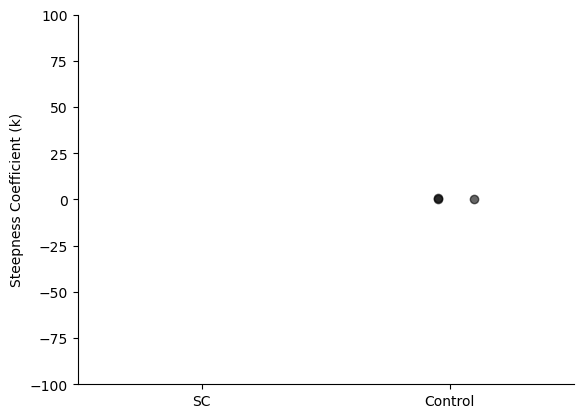

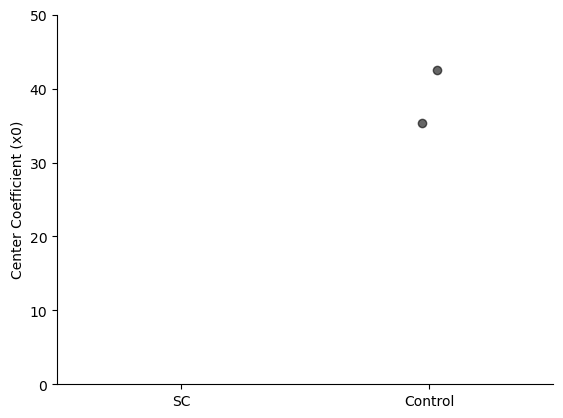

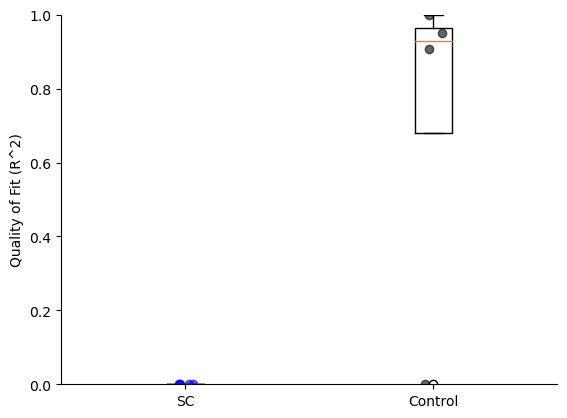

Steepness Coefficients (k):
SC: [nan, nan, nan, nan, nan]
Control: [0.24402193370022485, 0.037440825358097785, 0.9936930278787505, nan]

Center Coefficients (x0):
SC: [nan, nan, nan, nan, nan]
Control: [35.35645776407831, -142.32155321283366, 42.547728235395745, nan]

Quality of Fit (R^2):
SC: [0, 0, 0, 0, 0]
Control: [1.0, 0.9514184805245394, 0.9061489694876078, 0]


In [31]:


# boxplot of steepness coefficients: SC versus Control
plt.figure()
plt.boxplot([steepness_coefficients['SC'], steepness_coefficients['random']], labels=['SC', 'Control'])
x_jitter = np.random.normal(1, 0.04, size=len(steepness_coefficients['SC']))
plt.scatter(x_jitter, steepness_coefficients['SC'], color='b', alpha=0.6)
x_jitter = np.random.normal(2, 0.04, size=len(steepness_coefficients['random']))
plt.scatter(x_jitter, steepness_coefficients['random'], color='k', alpha=0.6)
# t-test, filter nan values
t_stat, p_val = ttest_ind(
    [x for x in steepness_coefficients['SC'] if not math.isnan(x)],
    [x for x in steepness_coefficients['random'] if not math.isnan(x)],
    equal_var=False
)
print(f'T-test between SC and Control steepness coefficients: t={t_stat:.3f}, p={p_val:.3f}')
plt.xlim(0.5, 2.5)
plt.ylim(-100, 100)
plt.ylabel('Steepness Coefficient (k)')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

# boxplot of center coefficients: SC versus Control
plt.figure()
plt.boxplot([center_coefficients['SC'], center_coefficients['random']], labels=['SC', 'Control'])
x_jitter = np.random.normal(1, 0.04, size=len(center_coefficients['SC']))
plt.scatter(x_jitter, center_coefficients['SC'], color='b', alpha=0.6)
x_jitter = np.random.normal(2, 0.04, size=len(center_coefficients['random']))
plt.scatter(x_jitter, center_coefficients['random'], color='k', alpha=0.6)

plt.xlim(0.5, 2.5)
plt.ylabel('Center Coefficient (x0)')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylim(0, 50)
plt.show()

# boxplot of quality of fit (R^2): SC versus Control
plt.figure()
plt.boxplot([quality_of_fit['SC'], quality_of_fit['random']], labels=['SC', 'Control'])
x_jitter = np.random.normal(1, 0.04, size=len(quality_of_fit['SC']))
plt.scatter(x_jitter, quality_of_fit['SC'], color='b', alpha=0.6)
x_jitter = np.random.normal(2, 0.04, size=len(quality_of_fit['random']))
plt.scatter(x_jitter, quality_of_fit['random'], color='k', alpha=0.6)

plt.xlim(0.5, 2.5)
plt.ylim(0, 1)
plt.ylabel('Quality of Fit (R^2)')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

print("Steepness Coefficients (k):")
print("SC:", steepness_coefficients['SC'])
print("Control:", steepness_coefficients['random'])

print("\nCenter Coefficients (x0):")
print("SC:", center_coefficients['SC'])
print("Control:", center_coefficients['random'])

print("\nQuality of Fit (R^2):")
print("SC:", quality_of_fit['SC'])
print("Control:", quality_of_fit['random'])

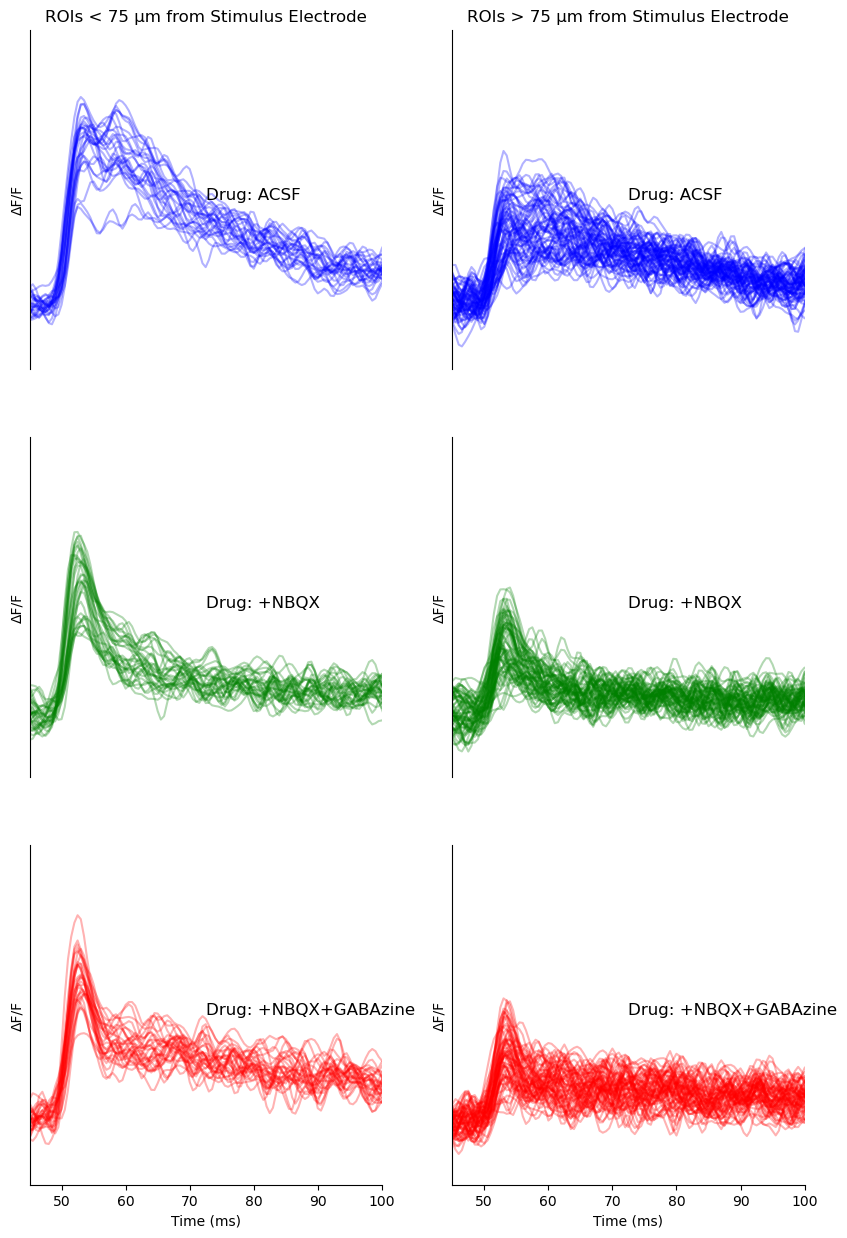

In [21]:
# drug comparison
date = '10/6/2025'
slic = 2
locs = [1, 2, 3]
recs = [3, 1, 1]
drugs = ['ACSF', '+NBQX', '+NBQX+GABAzine']

# 3 subplots, one for each location
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))
# show trace from each condition
for loc, rec, drug, ax, color in zip(locs, recs, drugs, axs, ['blue', 'green', 'red']):
    row = px_df[(px_df['Date'] == date) & (px_df['Slice'] == slic) & (px_df['Location'] == loc) & (px_df['Recording'] == rec)]
    stim_dist = row['Dist_from_Center'].values
    if not row.empty:
        trace_file = row.iloc[0]['trace']
        stim_current = row.iloc[0]['Stim_Current']
        traces = read_traces_file(trace_file)
        for i, col in enumerate(traces.columns):
            if col == 'Pt':
                continue
            if stim_dist[i-1] < 75:
                ax[0].plot(traces['Pt'] * 0.5, traces[col], label=f'{drug} ({stim_current} µA)', color=color, alpha=0.3)
            else:
                ax[1].plot(traces['Pt'] * 0.5, traces[col], label=f'{drug} ({stim_current} µA)', color=color, alpha=0.3)

for ax1, drug in zip(axs, drugs):
    for ax in ax1:
        ax.annotate(f'Drug: {drug}', xy=(0.5, 0.5), xycoords='axes fraction', fontsize=12)
        ax.set_ylabel('ΔF/F')
        ax.set_xlim(45, 100)
        ax.set_ylim(-1, 5)
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

axs[0][0].set_title('ROIs < 75 µm from Stimulus Electrode')
axs[0][1].set_title('ROIs > 75 µm from Stimulus Electrode')
for i in range(2):
    axs[2][i].set_xlabel('Time (ms)')
    axs[1][i].spines['bottom'].set_visible(False)
    axs[0][i].spines['bottom'].set_visible(False)
    axs[0][i].set_xticks([])
    axs[1][i].set_xticks([])
plt.show()